# Predicting Clutch Goalscorers in the NHL using Machine Learning Techniques

In this project, I explored various machine learning techniques to determine the best performing NHL forwards in close and tied games (often referred to as "clutch" moments). The process involved several key steps:

### 1. Identifying Correct Sources of Data
I needed to scrape data from the NHL API and Natural Stat Trick. The NHL API offers a good foundation for player bios and common goal statistics. However, Natural Stat Trick provided many advanced metrics as well as goals scored by players in close and tied games.

### 2. Data Cleaning
I merged data from the NHL API and Natural Stat Trick, then ensured the data was accurate and filtered appropriately.

### 3. Establishing a Definition of Clutch
I computed a "clutch score" for players by weighing the number of goals they scored in close and tied situations as well as in overtime.

### 4. Building a Classification Model
I attempted to classify players as "clutch" and "non-clutch" by setting thresholds for the clutch score. I used metrics such as expected goals, scoring chances, and other advanced statistics as features. The model was trained on data from the 2020-2021 to 2022-2023 NHL seasons. While the model was successful in identifying elite players and those below average, it struggled with players who fell near the classification boundaries, where small differences in their stats made it difficult to confidently label them as clutch or non-clutch.

### 5. Switching to a Regression Model
I realized that linear regression was a more feasible approach since many of the features were strongly correlated with a clutch score. It would, therefore, be easier to predict a player's clutch score rather than assigning the player an ambiguous label.  
I refined the model by using Ridge regression and performed cross-validation to ensure there was no overfitting.

### 6. Dealing with Outliers
I used Cook's Distance to identify influential points. I discovered that the model underpredicted the clutch score of elite players because their feature stats set a "ceiling" for their clutch ability. The model also overestimated some elite players who had strong underlying metrics but did not perform well in clutch games. In addition, the model struggled with below-average players who scored clutch goals at a rate that did not match their advanced stats.  
This prompted me to use a log transformation, which enabled the model to generate better predictions for elite players and significantly reduced the number of influential points. However, this transformation caused some inaccuracies for below-average players, as it amplified the difference between predicted and actual clutch scores for players with low stats.

### 7. Using the Model on a Final Test Set
After I was satisfied with the model, I used it to predict the clutch score of players based on their statistics from the start of the 2023-2024 season to the current point of the 2024-2025 season.  
In the coming weeks, I plan to deploy the model and connect it to a Power BI dashboard, which will provide real-time updates of a player's current clutch score and their predicted clutch score.


### Imports
These are the necessary imports for the project.

In [1]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General imports
import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# XGBoost and machine learning
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA

# Hyperparameter tuning with Skopt
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Saving Model
import joblib

### NHL API
The following snippet of code scrapes data from the NHL API for the 2020-2021 to 2022-2023 NHL seasons, while accounting for any issues that may occur when connecting to the API. It also combines a player's stats across these seasons.

In [2]:
all_seasons = []

for season in range(2020, 2023):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)

Successfully fetched data for season 2020-2021
Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023


### Cleaning the Scraped NHL API Data
The next step is to clean the data properly:
-  Only forwards are included since defensemen score at different rates. 
-  I kept players who appeared in at least 60 games across the three seasons (approximately 20 games each season). This ensured that there was a sufficient sample size for each player.
-  Finally, some columns are renamed to maintain a consistent naming format.

In [3]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)


### Scraping Data from Natural Stat Trick
The code below establishes URL links for the pages needed from Natural Stat Trick.

In [4]:
start_season = "20202021"
end_season = "20222023"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

### Scraping Data from Natural Stat Trick
The code below scrapes data from Natural Stat Trick and stores the data for each page in a dataframe.

In [5]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

### Cleaning Data from Natural Stat Trick
After scraping the data from Natural Stat Trick, only relevant columns are included for each dataframe. These dataframes are then merged into one dataframe containing all statistics from Natural Stat Trick.

Similar to the NHL API data, only players who have played at least 60 games are included.

The dataframes do not need to be filtered for forwards because it was easier to do this through the URLs.


In [6]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rebounds Created': 'rebounds_created'}, inplace=True)

### Standardize Player Names
Some players from Natural Stat Trick have different names compared to the NHL API. It is important to use standard names in both dataframes before merging them.


In [7]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Thomas Novak"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Tommy Novak"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [8]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rebounds_created,iCF
0,Joe Thornton,78,1,3,1,10,68,7.27,91,72,36,10,110
2,Jason Spezza,125,3,4,7,22,178,17.16,243,155,66,24,313
6,Eric Staal,125,3,2,8,19,188,21.77,253,206,106,28,328
7,Jeff Carter,209,10,11,11,49,493,51.65,618,450,236,89,781
8,Dustin Brown,113,5,5,6,26,275,30.32,364,241,122,22,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,Matty Beniers,90,6,4,8,27,166,22.91,244,174,85,14,306
755,Cole Sillinger,143,3,5,6,19,241,27.17,338,276,115,36,433
758,Wyatt Johnston,82,4,4,8,24,160,18.92,207,192,94,35,281
759,Mason McTavish,89,2,6,5,19,173,22.67,231,174,92,35,285


In [9]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,time_on_ice_per_game
0,8466138,Joe Thornton,C,78,20,0,744.77870
1,8469455,Jason Spezza,C,125,33,0,653.25985
2,8470595,Eric Staal,C,125,23,1,868.72430
3,8470604,Jeff Carter,C,209,55,2,958.84570
4,8470606,Dustin Brown,R,113,33,0,970.80450
...,...,...,...,...,...,...,...
486,8482665,Matty Beniers,C,90,39,1,1020.96250
487,8482705,Cole Sillinger,C,143,23,0,810.29235
488,8482740,Wyatt Johnston,C,82,17,0,928.90240
489,8482745,Mason McTavish,C,89,27,0,853.62010


### Merging the Data
The dataframes containing the information from the NHL API and Natural Stat Trick are merged.

In [10]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'inner')

In [11]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,time_on_ice_per_game,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rebounds_created,iCF
0,8466138,Joe Thornton,C,78,20,0,744.77870,78,1,3,1,10,68,7.27,91,72,36,10,110
1,8469455,Jason Spezza,C,125,33,0,653.25985,125,3,4,7,22,178,17.16,243,155,66,24,313
2,8470595,Eric Staal,C,125,23,1,868.72430,125,3,2,8,19,188,21.77,253,206,106,28,328
3,8470604,Jeff Carter,C,209,55,2,958.84570,209,10,11,11,49,493,51.65,618,450,236,89,781
4,8470606,Dustin Brown,R,113,33,0,970.80450,113,5,5,6,26,275,30.32,364,241,122,22,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,8482665,Matty Beniers,C,90,39,1,1020.96250,90,6,4,8,27,166,22.91,244,174,85,14,306
486,8482705,Cole Sillinger,C,143,23,0,810.29235,143,3,5,6,19,241,27.17,338,276,115,36,433
487,8482740,Wyatt Johnston,C,82,17,0,928.90240,82,4,4,8,24,160,18.92,207,192,94,35,281
488,8482745,Mason McTavish,C,89,27,0,853.62010,89,2,6,5,19,173,22.67,231,174,92,35,285


### Null values
Check that there are no Null values after merging.

In [12]:
merged_clutch_goals = merged_clutch_goals.fillna(0)
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, time_on_ice_per_game, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rebounds_created, iCF]
Index: []


### Changing Columns
Drop the "GP" column since it existed in both previously merged dataframes.

Compute per game stats to accurately compare players.

In [13]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


### Clutch Score
After cleaning the data, we can now compute a weighted clutch score for each player.
- Goals scored when tied and down by one are given the most weighting since these are the most representative of high-pressure situations.
- Goals scored when up by one are still close situations but may not be as "clutch" compared to goals scored when tied and down by one.
- OT goals are also given a smaller weight, since they occur infrequently compared to other goals. They are also only scored during 3v3 play, which differs from the traditio5nal v5.


In [14]:
merged_clutch_goals['clutch_score'] = 0.3 * merged_clutch_goals['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.2 * merged_clutch_goals['ot_goals_per_game']

### Rankings Players Based on their Clutch Score
All scores are multiplied by 100 to make them more interpretable.
The scores are then ranked and the top 20 players are shown below.

In [15]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
334,Auston Matthews,14.22,1.0
283,Connor McDavid,12.75,2.0
253,David Pastrnak,12.52,3.0
239,Leon Draisaitl,12.13,4.0
320,Kirill Kaprizov,11.87,5.0
54,Max Pacioretty,10.76,6.0
339,Alex DeBrincat,10.32,7.0
399,Jason Robertson,10.24,8.0
14,Alex Ovechkin,10.21,9.0
290,Sebastian Aho,10.00,10.0


### Distribution of Clutch Scores
As shown by the histogram below, the data for clutch scores is right skewed. Most players have a below average clutch score and there are a small number of elite players


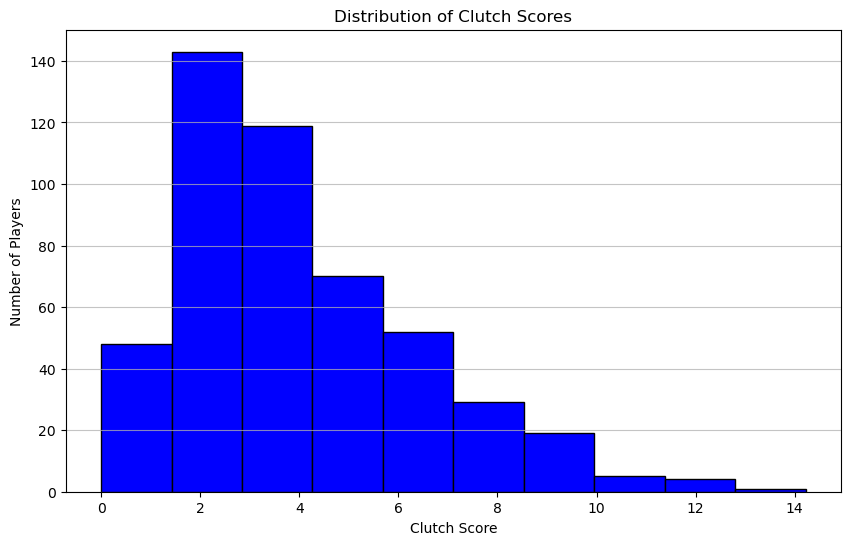

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

### Threshold for Clutch Scores
It makes sense to label "clutch" goalscorers as a higher percentile of data. Thus, all players who had a clutch score in the 85th percentile were in the positive class.
This approach already highlights the potential shortcomings of classification for this project. Is a player in the 80 to 84th percentile suddenly not "clutch"? Even if we used a multiclass classification approach, how can we distinguish between players who fall near the boundaries?

In [17]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

### Class Imbalance
Due to the right skew distribution of the data, there are very few goalscorers classified as "clutch".

In [18]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    416
1     74
Name: count, dtype: int64

### Setting up a Classification Model

My initial approach was to select various classification models (e.g. XGBoost, random forest, KNN) and compare them with the Friedman statistical test. I started working on an XGBoost model, but then realized that a classification approach was not idea.


### Starting with XGBoost

XGBoost builds an ensemble of decision trees by correcting the prediction errors of previous trees.

Many statistics relevant to a player's goalscoring (e.g. shooting, assists, ice time) are used as features. The model is then trained on an 80-20 split of the data. The **stratify = y** parameter ensures that the training and testing sets have the same class distribution as the original dataset (i.e. same representation of the number of clutch and non-clutch goalscorers). Therefore, the minority class (clutch goalscorers) will not be underrepresented.

The model uses the log loss evaluation metric, which measures the difference between the true class labels (0 or 1) and the predicted probabilities fir the positive class. A greater difference between the predicted probabilities and the actual labels results in a higher log loss. 

A full glossary of the features can be found on the __[Natural Stat Trick website.](https://www.naturalstattrick.com/glossary.php?players)__


In [19]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game','time_on_ice_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Initial Evaluation of the Model

The XGBoost model is evaluated using StratifiedKFold cross-validation with 10 splits. Four metrics are used to assess the model's performance: accuracy, precision, recall, and F1 score.

With 10-fold cross-validation, the dataset is divided into 10 groups. We train the model on 10 - 1 = 9 groups and test the model (evaluate its metrics) on the remaining group. This process is repeated 10 times to ensure every group serves as a test set. The metrics are then average across the 10 folds.

As with stratify = y, each fold has the same class distribution as the original dataset (i.e. same representation of the number of clutch and non-clutch goalscorers).

### Definitions of Metrics

Accuracy: The proportion of correct predictions among the total number of predictions.

Precision: The proportion of true positives among all instances predicted as positive. It answers the question: "When we predicted positive (a player classified as clutch), how many times were we correct?"

Recall: The proportion of true positives among all actual positives. It answers the question: "Of all the actual positives (clutch goalscorers), how many did the model correctly identify?"

F1 Score: The harmonic mean of precision and recall. Taking the harmonic mean ensures the F1 Score is not skewed by extreme values of precision and recall.

### Inflated Accuracy

The model's accuracy appears to be quite high (approximately 90%), but this is most likely due to the high class imbalance. The model can predict the majority class most of the time, without effectively learning to identify the minority class.

The model seems to have a high precision and low recall. It is very cautious about predicting the minority class (clutch goalscorers), which results in fewer false positives. So when the model predicits positive, it is mostly correct. However, this means that the model misses many clutch goalscorers and has a low recall. 

The F1 score is pulled down by the low recall to highlight the model's issues with rarely predicting the positive class and missing clutch goalscorers.

In [20]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.211789
score_time        0.019645
test_accuracy     0.897959
test_precision    0.876048
test_recall       0.623214
test_f1           0.637532
dtype: float64

### Learning Curves
The learning curves plot the log loss of the training against the log loss for cross-validation. The very low log loss for training indicates that the model has nearly 100% accuracy in predicting clutch players from the training data. However, the log loss increases to 0.4 on the cross-validation data. Due to the high negative class imbalance, the model can just predict non-clutch most of the time. When it predicts the positive class, it may not be confident enough which shows the model has memorized the patterns in the training data and cannot generalize to new data during cros- validation


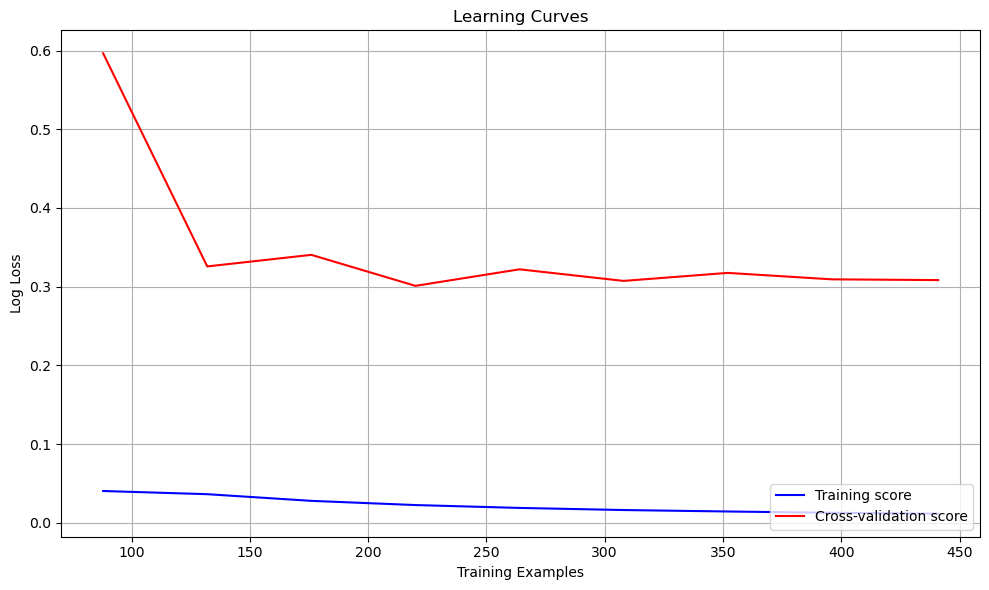

In [21]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Feature importance
Feature importance helps us to determine which features the model relies on during training and remove less influential features. This enables the model to focus on the most relevant information when training and improve its ability to generalize to unseen data.

The F score (Feature Importance score) reflects how frequently a feature contributes to the decision-making process in the model. For gradient boosting models, importance is based on the improvement in the loss function when a feature is used to split the data within the trees.


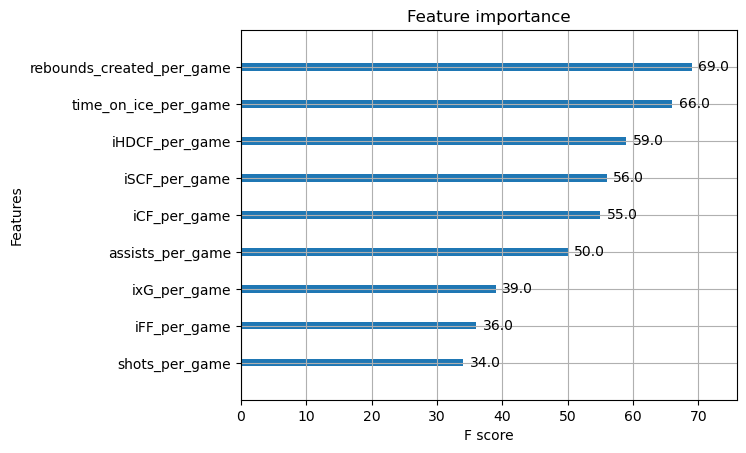

In [22]:
plot_importance(xgb_model)
plt.show()

### Obtaining the Most Important Features
The following lines of code obtain all features with an F score greater than 40.

In [23]:
importance = xgb_model.get_booster().get_score(importance_type='weight')
important_features = {}

for feature, score in importance.items():
    if score >= 40:
        important_features[feature] = score

important_feature_names = list(important_features.keys())

X_adjusted = merged_clutch_goals[important_feature_names]  


### Hyperparameter tuning
Hyperparameter tuning involves adjusting parameters to improve the model's metrics and reduce overfitting. These parameters are set before training since the model cannot learn them from the data. Below are hyperparameters that are tuned for the XGBoost model:

- **max_depth:** This controls the maximum depths of the trees. Although a greater depth allows the model to capture more intricate patterns in the data, it can start memorizing patterns in the data and overfit.

- **min_child_weight:** As each node is split based on a condition, data is passed down to nodes. min_child_weight is the minimum number of samples that a node must hold before it is split further. If there are less than min_child_weight samples at that node, the node will not be split further. This means that the node becomes a leaf.

    A higher min_child_weight means that a split will only occur if there is enough data and the model will not overfit to small non-representative samples of the data.

- **n_estimators:** n_estimators represents the number of trees that the model will use during training. As with depth, a higher number of trees can help the model identify more complex patterns in the data. However, the model can become too complex and may start memorizing the data. This will lead to overfitting.

- **learning_rate:** learning_rate controls how much each tree's contribution is scaled during training.
  
    A lower learning rate means that each tree's contribution is smaller, and the model will make smaller adjustments after adding a new tree. This can help the model generalize the data, but may also require more trees, thus leading to overfitting.

    A higher learning rate means each tree's contribution is larger and the model will make larger adjustments after adding a new tree. This can lead to a faster solution but cause the model to miss important details in the data and overfit.

- **reg_alpha:** This parameter helps to reduce the number of features considered in splits. If a feature has no or little contribution in splits, reg_alpha pushes its weight to 0. This enables the model to focus on important features and leads to better generalization.

- **reg_lamda:** reg_lamda adds a penalty to the squared values of the feature weights that are have no or little contribution in splits. This discourages large weights but does not force weights to zero, unlike reg_alpha. This leads to better generalization without necessarily eliminating features.

- **subsample:** subsample controls the fraction of data that is randomly sampled for training in each tree. By limiting the amount of training data, subsample prevents the model from memorizing details in the data and leads to less overfitting.

- **colsample_bytree :** This parameter controls the fraction of features that are randomly sampled for each tree. Since colsample_bytree limits the number of features used in each tree, it prevent the model from becoming overly dependent on any single feature and leads to better generalization.


In [24]:
from scipy.stats import randint, uniform

param_grid = {
    'max_depth': randint(2, 6),
    'min_child_weight': randint(2, 4),
    'n_estimators': randint(200, 301), 
    'learning_rate': uniform(0.03, 0.01),
    'reg_alpha': uniform(0.75, 0.6), 
    'reg_lambda': uniform(0.75, 0.6), 
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3) 
}


### Random Search
Random search is a hyperparameter tuning technique that randomly samples hyperparameter combinations from the parameter grid. The model is then trained and evaluated using k-Fold cross-validation on k - 1 subsets of the training data. The cross-validation score (in this case, F1 score) is calculated for the test fold, and the average score across all k iterations is used to evaluate the performance of that particular set of hyperparameters. This method helps to find a good set of hyperparameters without exhaustively testing every possible combination, unlike grid search.

I have repeated random search multiple times on different train and test splits to obtain a good representation of the model's performance. After each train and test split, the model's class weights are adjusted.


### Results of Hyperparameter Tuning

From the learning curves, it seems that hyperparameter tuning has helped to reduce overfitting.

With regards to the model's performance metrics, it is simply not enough to look at the recall and precision score. We must understand where the model is misclassifying clutch players.

After each randomly selected train test split, I printed out the model's classification results. It appears that the model can correctly classify higher ranked players but struggles with players close to the boundary points (ranks between 45 and 74). The model also incorrectly classifies players with varying performance over the three seasons. 

This makes sense because we are essentially assigning an ambiguous label to a clutch player. Is a player 0n the 84th to 83rd percentile suddenly not clutch? Classification may also have difficulties detecting trends in player performance.


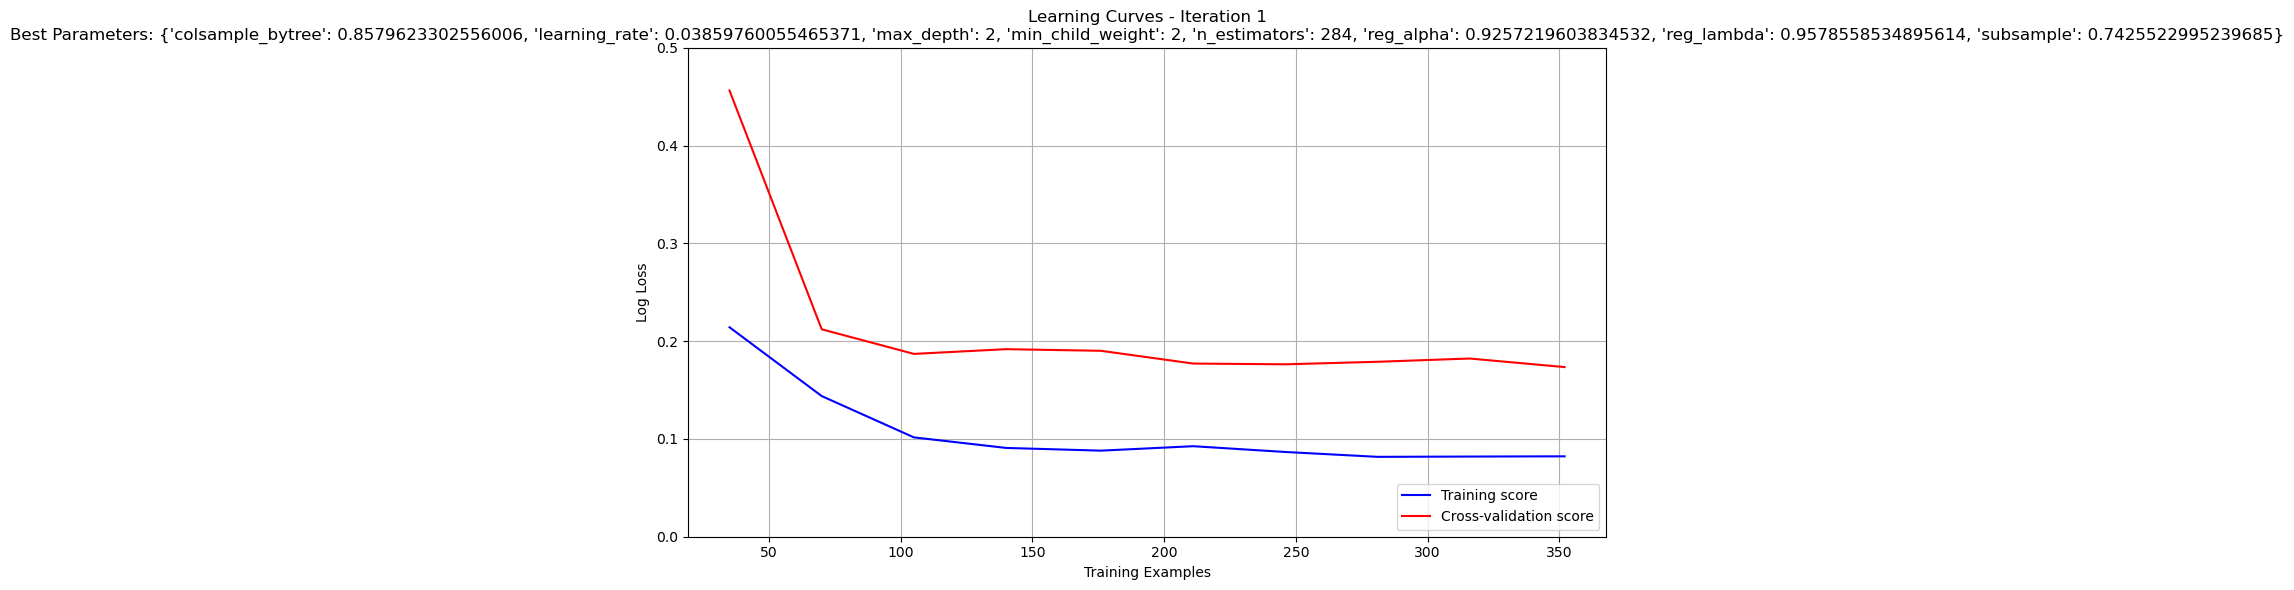


Precision Score:  0.6875
Recall Score:  0.7333333333333333

Correct Classfications
                 Player  clutch_score_rank  Actual  Predicted
219   Aleksander Barkov               13.0       1          1
27        Brad Marchand               38.0       1          1
150      Mark Scheifele               29.0       1          1
284         Jack Eichel               67.0       1          1
108  Vladimir Tarasenko               66.0       1          1
280         Kyle Connor               20.0       1          1
287      Mikko Rantanen               11.0       1          1
242      Nikolaj Ehlers               25.0       1          1
149      Mika Zibanejad               31.0       1          1
241    William Nylander               16.0       1          1
286          Timo Meier               44.0       1          1

Missed Cltuch Players
               Player  clutch_score_rank  Actual  Predicted
22         T.J. Oshie               74.0       1          0
404       Josh Norris        

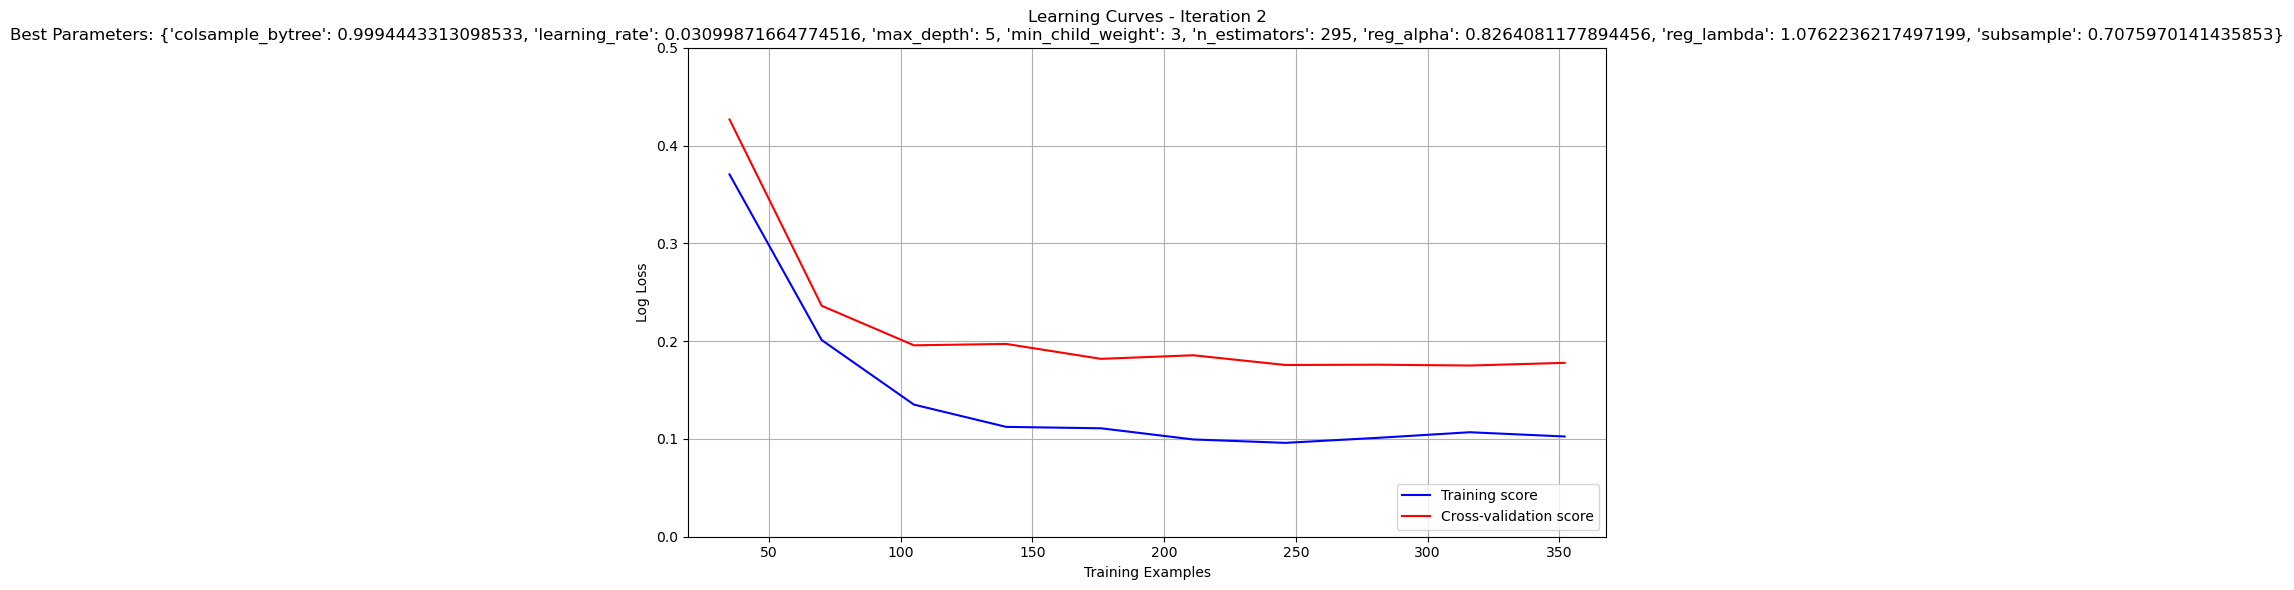


Precision Score:  0.7647058823529411
Recall Score:  0.8666666666666667

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
54     Max Pacioretty                6.0       1          1
60     Steven Stamkos               19.0       1          1
138      Boone Jenner               59.0       1          1
239    Leon Draisaitl                4.0       1          1
242    Nikolaj Ehlers               25.0       1          1
200     Jake Guentzel               27.0       1          1
14      Alex Ovechkin                9.0       1          1
361     Tage Thompson               14.0       1          1
27      Brad Marchand               38.0       1          1
218  Nathan MacKinnon               12.0       1          1
399   Jason Robertson                8.0       1          1
244       Kevin Fiala               68.0       1          1
223         Bo Horvat               33.0       1          1

Missed Cltuch Players
                 Player  clutch_score_ran

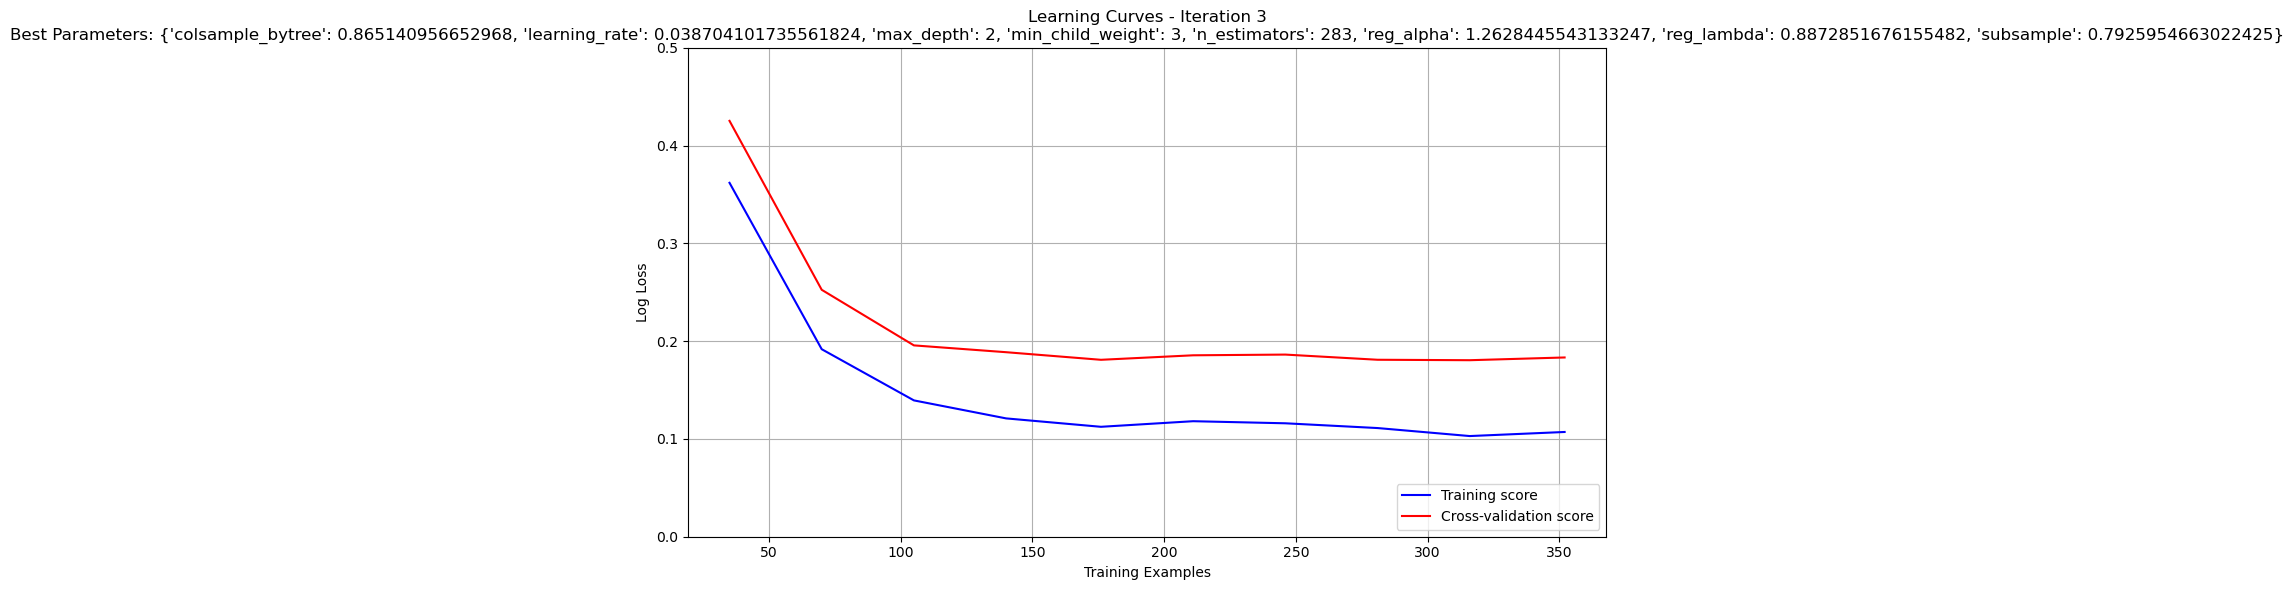


Precision Score:  0.7647058823529411
Recall Score:  0.8666666666666667

Correct Classfications
                    Player  clutch_score_rank  Actual  Predicted
290          Sebastian Aho               10.0       1          1
242         Nikolaj Ehlers               25.0       1          1
399        Jason Robertson                8.0       1          1
10        Patrice Bergeron               54.0       1          1
426          Brady Tkachuk               42.0       1          1
158  Jonathan Marchessault               72.0       1          1
239         Leon Draisaitl                4.0       1          1
221         Elias Lindholm               50.0       1          1
219      Aleksander Barkov               13.0       1          1
455          Cole Caufield               33.0       1          1
108     Vladimir Tarasenko               66.0       1          1
262          Brayden Point               26.0       1          1
112           Jeff Skinner               62.0       1      

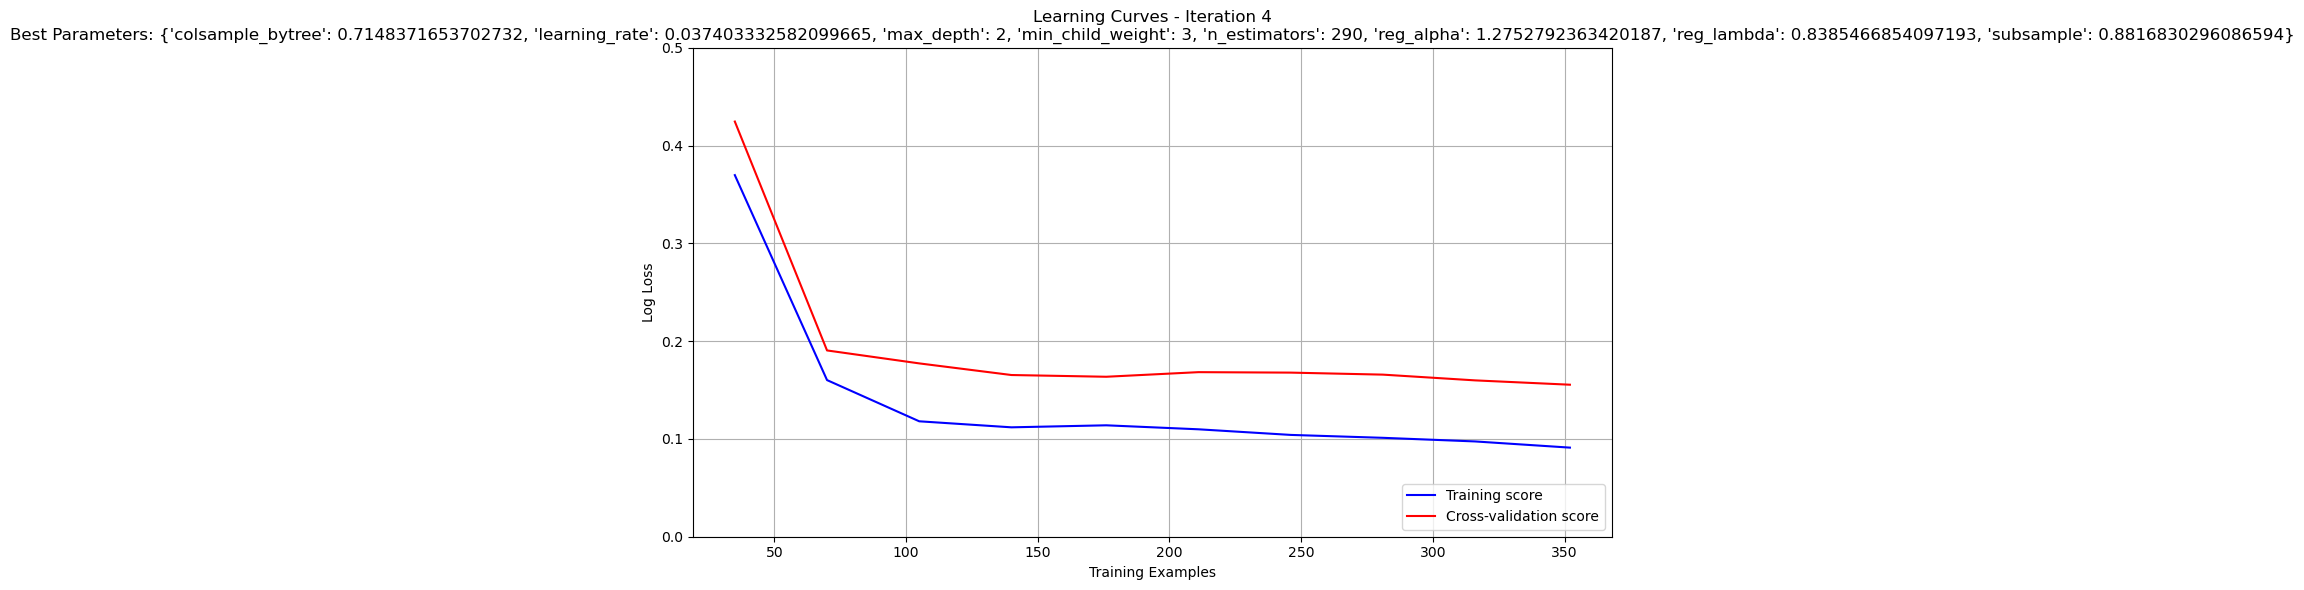


Precision Score:  0.8333333333333334
Recall Score:  0.6666666666666666

Correct Classfications
             Player  clutch_score_rank  Actual  Predicted
239  Leon Draisaitl                4.0       1          1
238    Sam Reinhart               43.0       1          1
60   Steven Stamkos               19.0       1          1
242  Nikolaj Ehlers               25.0       1          1
152     J.T. Miller               60.0       1          1
339  Alex DeBrincat                7.0       1          1
253  David Pastrnak                3.0       1          1
287  Mikko Rantanen               11.0       1          1
20    Sidney Crosby               32.0       1          1
80     John Tavares               55.0       1          1

Missed Cltuch Players
                 Player  clutch_score_rank  Actual  Predicted
86        Chris Kreider               18.0       1          0
81         Matt Duchene               45.0       1          0
489     Andrei Kuzmenko               22.0       1       

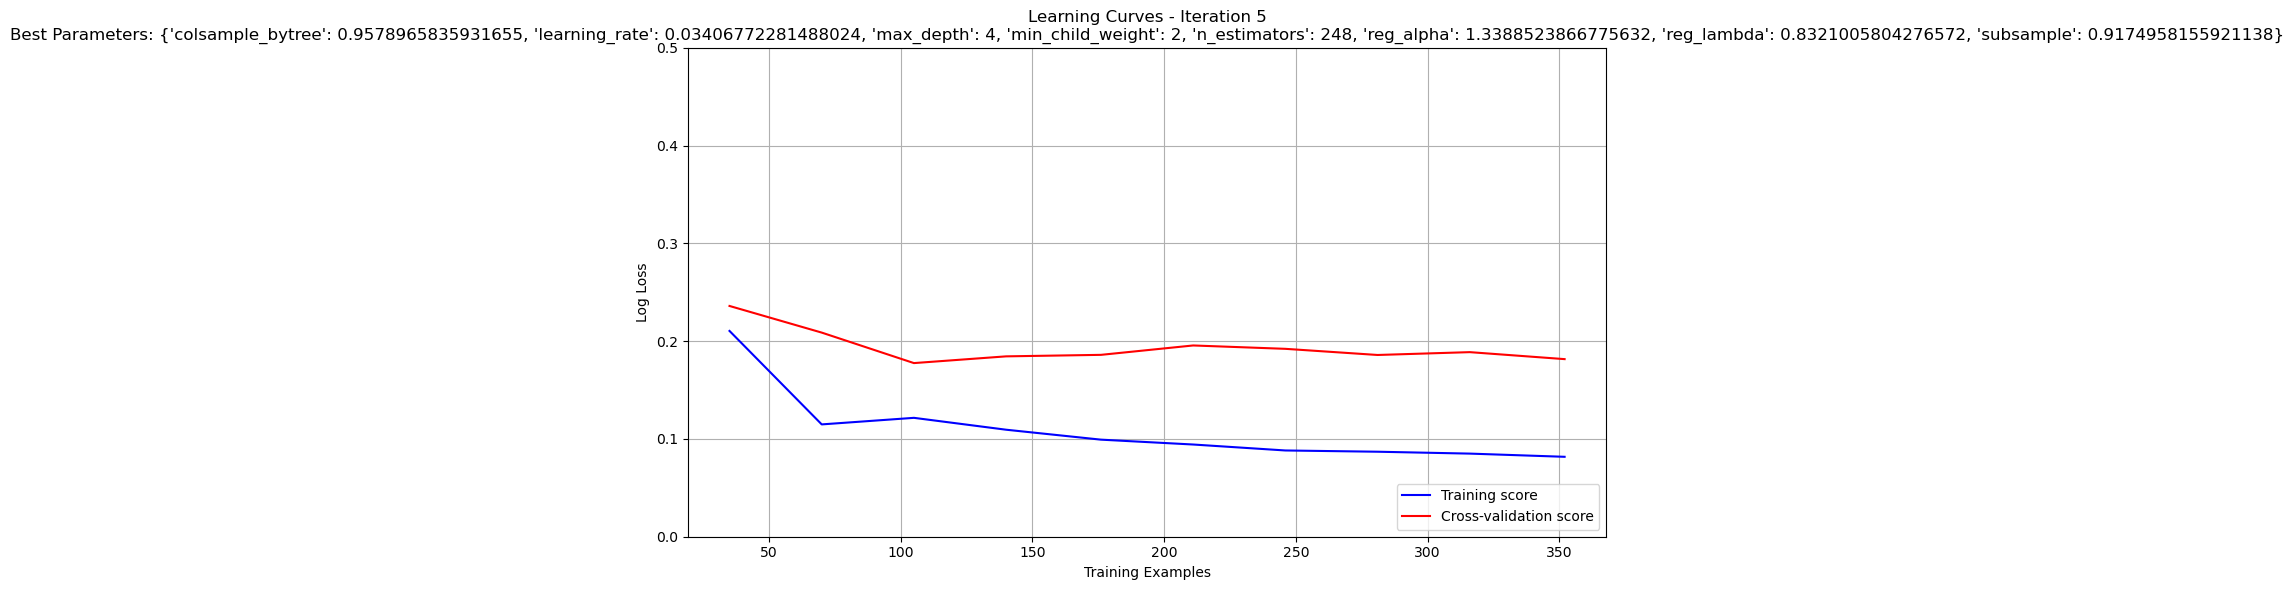


Precision Score:  0.75
Recall Score:  0.8

Correct Classfications
                Player  clutch_score_rank  Actual  Predicted
152        J.T. Miller               60.0       1          1
54      Max Pacioretty                6.0       1          1
241   William Nylander               16.0       1          1
27       Brad Marchand               38.0       1          1
354       Jordan Kyrou               63.0       1          1
458        Jack Hughes               24.0       1          1
455      Cole Caufield               33.0       1          1
320    Kirill Kaprizov                5.0       1          1
219  Aleksander Barkov               13.0       1          1
242     Nikolaj Ehlers               25.0       1          1
239     Leon Draisaitl                4.0       1          1
146  Gabriel Landeskog               30.0       1          1

Missed Cltuch Players
                 Player  clutch_score_rank  Actual  Predicted
147  Jonathan Huberdeau               70.0       1     

In [25]:
from sklearn.model_selection import RandomizedSearchCV

cv = StratifiedKFold(n_splits=10)

precision_list = []
recall_list = []
f1_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Log Loss')
    plt.ylim(0, 0.5)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(5):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = RandomizedSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, n_jobs = -1, scoring = 'f1')

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("")
    print("Precision Score: ", precision)
    print("Recall Score: ", recall)
    print("")

    
    results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[test_y.index, 'Player'],
    'clutch_score_rank': merged_clutch_goals.loc[test_y.index, 'clutch_score_rank'],
    'Actual': test_y,
    'Predicted': y_pred,
    })

    print("Correct Classfications")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 1)])

    print("")

    print("Missed Cltuch Players")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 0)])

    print("")

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

### Switching to Regression

Although the classification model does show advantages in correctly classifying some player, I believe that regression is more suitable:

1. Unlike Classification, regression can be used to predict the player's clutch score (a continuous label), rather than assigning them to classes that may not clearly define a "clutch player". This makes the model easier to interpret and leads to more accurate predictions.
2. Regression can account for the trends in player performance and provide better predictions.


### Features
The same features from classification are used. These features show a strong positive correlation with clutch score, which indicates that a linear regression model is suitable


In [26]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.882954
ixG_per_game                 0.884833
iFF_per_game                 0.886259
iSCF_per_game                0.897483
iHDCF_per_game               0.727755
assists_per_game             0.769966
iCF_per_game                 0.880728
rebounds_created_per_game    0.768760
time_on_ice_per_game         0.796485
dtype: float64


### Scatter Plots
The scatter plots further show the strong positive correlation of the features with clutch score.

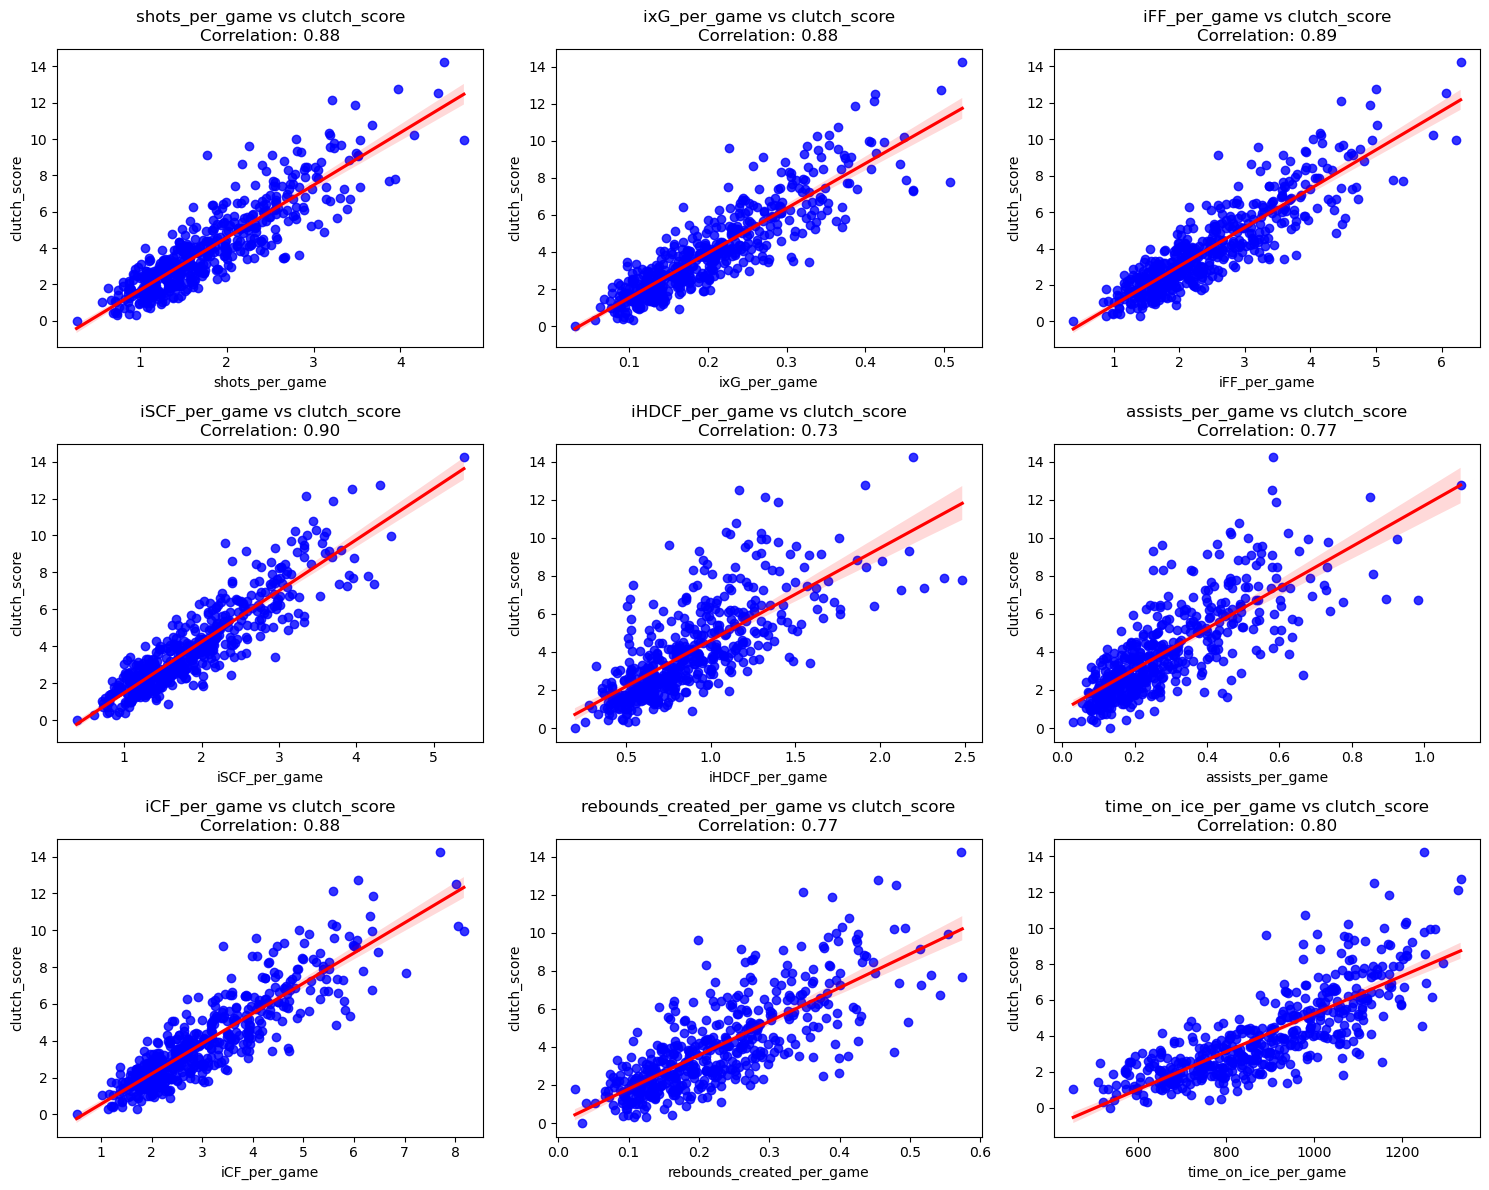

In [27]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 3, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

### Multicollinearity
Even though the features are highly correlated with each other, we should not expect any change in predictive performance because the correlations will exist in the test and training set. The model can still use the correlated features to make accurate predictions because the feature patterns learned during training will apply similarly in the test set.

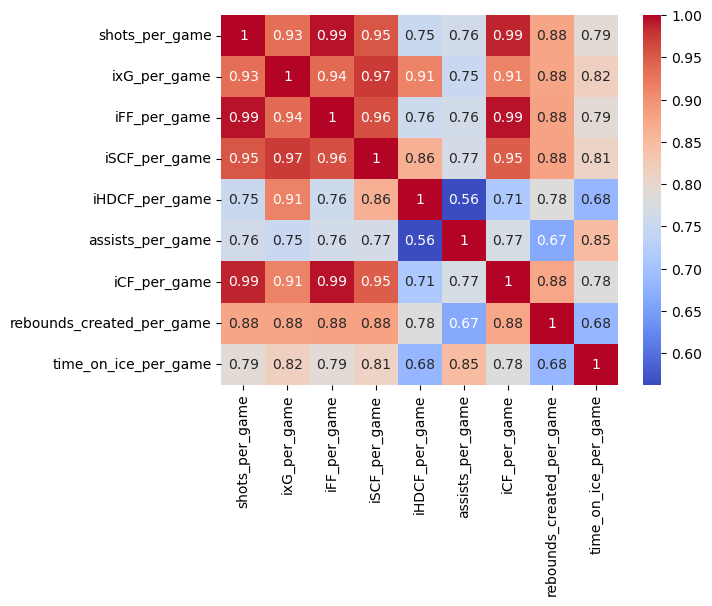

In [28]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

### Ridge Regression
Ridge Regression is a variant of linear regression that applies a penalty to the squared values of the coefficients in the regression equation. The penalty is controlled by the alpha parameter, which determines the strength of regularization. A higher value of alpha applies a stronger penalty which decreases the coefficients more. Unlike Lasso Regression, Ridge Regression does not set coefficients to zero and eliminate features. It instead keeps all features in the model but reduces the influence of less important features by shrinking their coefficients

Decreasing coefficients reduces the complexity of the model since the model will not become heavily reliant on certain features. It can instead focus on relevant features and generalize to unseen data.

We also must scale the data by setting the mean of each feature to 0 and standard deviation to 0, so that not one single feature dominates the model.
.


### Metrics
- MSE (Mean Squared Error): MSE measures the average squared difference between the predicted values and the actual values. Lower values indicate better model performance. It penalizes large errors more because the differences are squared.

- RMSE (Root Mean Squared Error): RMSE is the square root of MSE. It provides errors in the same units as the original data, making it easier to interpret. Like MSE, lower values are better, and it emphasizes larger errors due to squaring.

- MAE (Median Absolute Error): MAE is the median of the absolute differences between predicted and actual values and is not skewed by large errors, unlike MSE and RMSE.
    
- R²: R² represents the proportion of the variance in the dependent variable (y) that is explained by the independent variable(s) (x) in the model. In other words, it shows how well the changes in x can explain or predict the changes in y. Values closer to 1 indicate that the model explains most of the variability in y, meaning a better fit, while values closer to 0 suggest that the model explains little of the variability in y, meaning a poorer fit. However, R^2 can be inflated by overfitting. As more predictors are features to the data, R^2 increases because the model can explain more variance in y, even if the features are not important.

- Adjusted R²: Adjusted R² adjusts R² for the number of predictors in the model. It accounts for overfitting by penalizing excessive use of unhelpful features. Like R², higher values are better.


In [29]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

X_scaled = StandardScaler().fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas_random = np.random.uniform(0.0001, 1000, 50)

ridge_cv = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  1.057231287823188
RMSE:  1.0282175294280818
MAE:  0.6819480548760612
R²:  0.8490894007856499
Adjusted R²:  0.8455339154638458


### Learning Curves
It is important to evaluate the learning curves for ridge regression to determine if there is overfitting in the model. 

Although many of scikit-learn’s metrics are regarded as better when they return higher values, MSE is a loss function. Therefore, we take the negative value of MSE for the learning curve since higher positive values of MSE will yield more negative values.

### Interpreting the Graph


The MSE is multiplied by one, so the learning curve graph shows positive MSE and is easier to interpret (as smaller values of MSE are better).

The learning curves do not show significant overfitting. After approximately 250 samples, both training and validation curves converge to an MSE of less than 
2.
Thus, Ridge Regression is the correct choice for generalizing the training data.


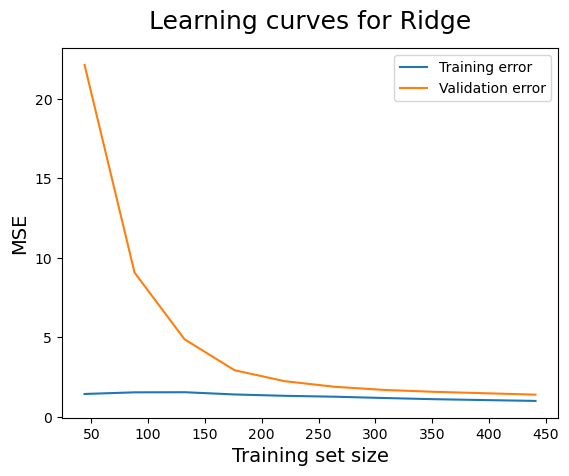

In [30]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

### Analyzing the Residuals
It is important to not just look at MSE and MAE, but also where the model is having issues with predicting the clutch scores of players.

From the dataframe below, it appears the model is underpredicting many elite players who excel in close and tied situations.

In [31]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(60))

All predictions and actual values:
                  Player  Actual  Predicted     Error
334      Auston Matthews   14.22  11.396320  2.823680
432    Andrei Svechnikov    5.33   7.802998  2.472998
290        Sebastian Aho   10.00   7.720932  2.279068
479        Cole Perfetti    1.88   3.995226  2.115226
60        Steven Stamkos    9.30   7.191027  2.108973
332      Matthew Tkachuk    7.28   9.208609  1.928609
98        Calle Jarnkrok    5.48   3.551842  1.928158
220      Jonathan Drouin    1.62   3.479236  1.859236
208     Andre Burakovsky    6.43   4.613185  1.816815
117      Mikael Granlund    2.52   4.313175  1.793175
223            Bo Horvat    8.29   6.624437  1.665563
241     William Nylander    9.58   7.953242  1.626758
143     William Karlsson    3.71   5.319468  1.609468
342     Jesse Puljujarvi    2.97   4.550282  1.580282
51          Patrick Kane    6.14   7.674463  1.534463
240          Sam Bennett    5.22   6.746383  1.526383
285      Jordan Greenway    2.00   3.500419  1.

### Scatter Plot and Line of Best Fit
Since most points fall near the line of best fit, the model is generally accurate in predicting values. However, there are a few outliers which need to be corrected.

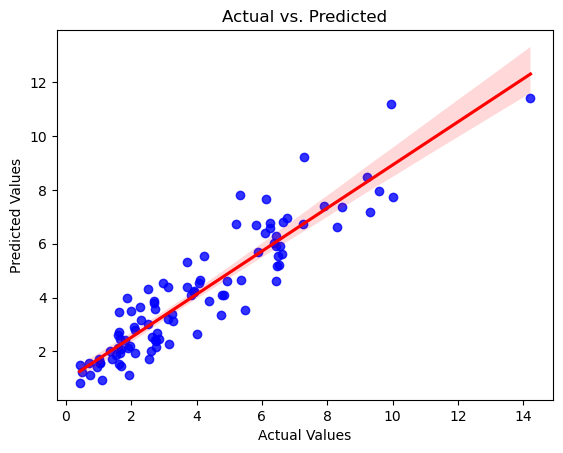

In [32]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Residual Plot
The residual plot shows more errors in predicting the clutch score are between 1 and -1. However, there are a few points outside of this range, which may be considered as outliers.

<Axes: xlabel='clutch_score'>

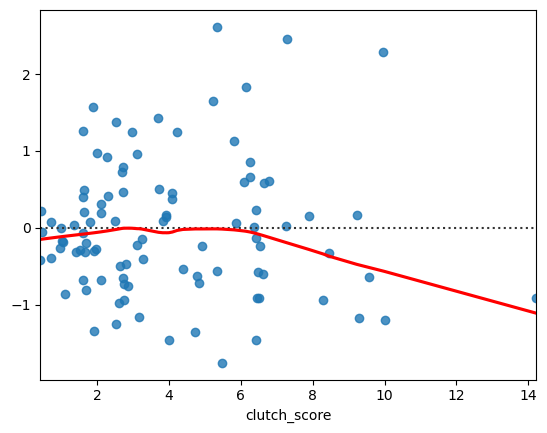

In [33]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

### Cook's Distance
Cook's distance enables us to evaluate influential points in the model. Influential points are data points that significantly change the fit of the model if removed.

Cook's distance combines residuals (difference between the observed and predicted values) and leverage (how far away a data point is from the average of the predictor values) to determine the effect of the fit and predictions of a model when a data point is removed. A Cook's distance larger than the threshold (4 / n, with n being the number of observations) suggests that removing a particular data point would significantly change the model.

As shown below, the model tends to underestimate the performance of several elite players (e.g., McDavid and Matthews) in clutch situations. These players' statistics may have created an artificial "ceiling" that limits the model’s ability to accurately predict their scoring ability in close and tied situations.

Conversely, the model overestimates the performance of other elite players (e.g., Kucherov and both Tkachuks), who do not perform as well in clutch scoring situations as their general statistics suggest.


There are 45 influential points.
Outliers based on Cook's Distance:
                  Player  Actual  Predicted  Cook's Distance
334      Auston Matthews   14.22  12.062853         0.070461
283       Connor McDavid   12.75  11.602638         0.023405
253       David Pastrnak   12.52  10.384466         0.034058
239       Leon Draisaitl   12.13   9.763624         0.038212
320      Kirill Kaprizov   11.87   9.201083         0.018471
54        Max Pacioretty   10.76   8.583603         0.020553
339       Alex DeBrincat   10.32   8.947553         0.015284
399      Jason Robertson   10.24   7.575257         0.034294
290        Sebastian Aho   10.00   8.030088         0.012663
218     Nathan MacKinnon    9.95  11.389116         0.019361
219    Aleksander Barkov    9.78   8.237749         0.009001
361        Tage Thompson    9.69   7.298691         0.014655
245          Jakub Vrana    9.60   5.390432         0.036714
171       Filip Forsberg    9.49   7.826739         0.012543
86         Chris 

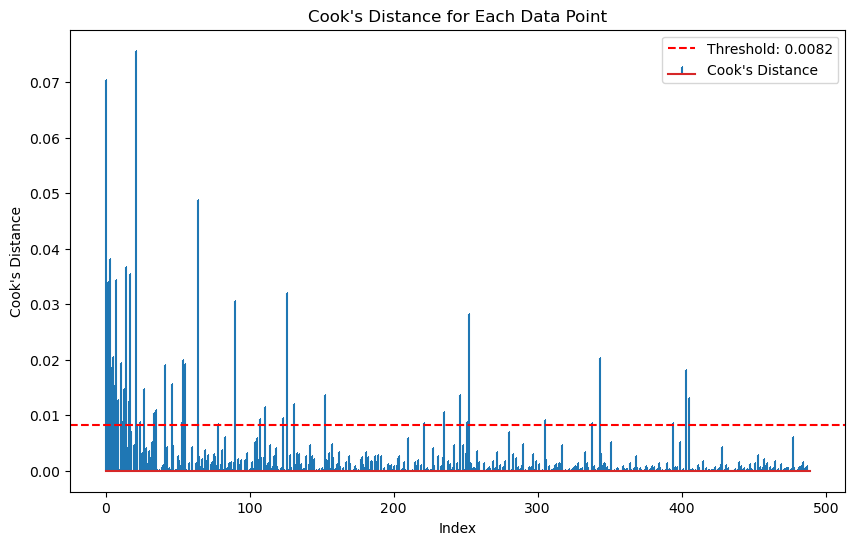

In [34]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()


### Evaluating the Distribution of the Data

The histogram and QQ plot show that the data has a right skew distribution, which may explain why the model has difficulties in predicting the clutch score of elite players on the right side of the tail.


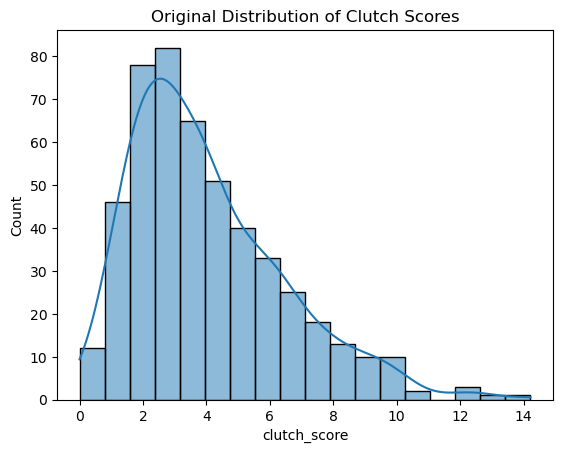

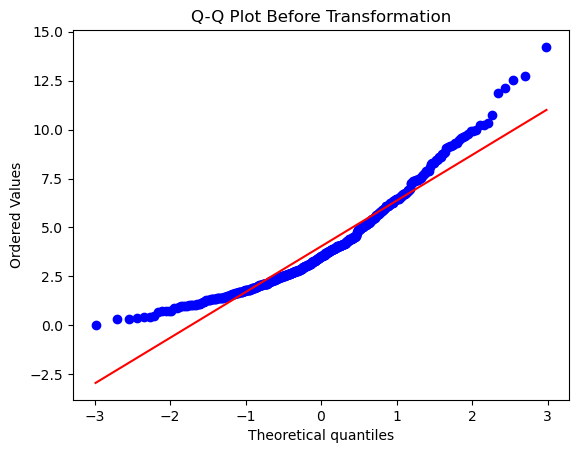

In [35]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()
stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

### Transforming the Data to a Normal Distribution with Log

As shown below, a log transformation is used to reduce the skew of the data and create a normal distribution. This ensures the predictions are not affected by the influential points we identified in Cook's distance.


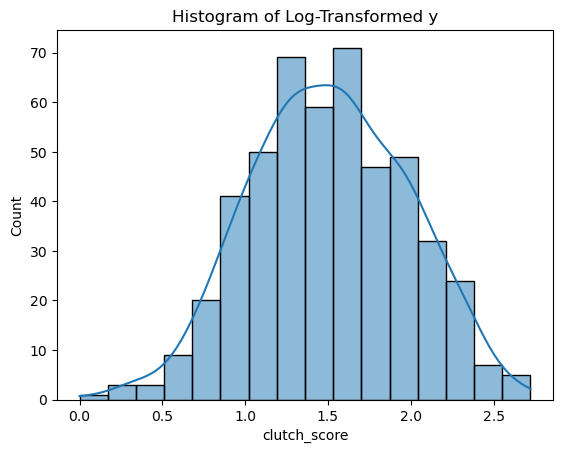

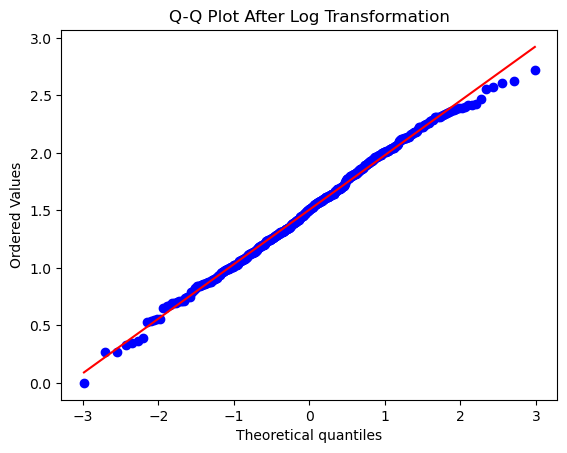

In [36]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

### Evaluating Metrics after the Log Transformation

After using a log transformation, it appears that the residuals have significantly decreased. However, it is important to remember the scale of the data has changed and we must look at the model's predictions of certain data points.

In [37]:
epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

y_log = np.log(y + 1)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=200
)

alphas_random = np.random.uniform(0.0001, 1000, 50)
ridge_cv_log = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))


MSE:  0.047812046972909535
RMSE:  0.21865966014084431
MAE:  0.1615009247820549
R²:  0.8000299888551774
Adjusted R²:  0.795318653514069


In [38]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(55))

All predictions and actual values:
                  Player    Actual  Predicted     Error
56          Carl Hagelin  0.824175   1.306264  0.482088
388  Kristian Vesalainen  0.270027   0.751809  0.481782
479        Cole Perfetti  1.057790   1.515107  0.457317
444         John Leonard  0.810930   1.220221  0.409291
409          David Kampf  0.896088   1.303174  0.407086
92   Nicolas Deslauriers  0.693147   1.093397  0.400250
120       Joonas Donskoi  1.064711   1.448861  0.384150
232       Ryan Carpenter  0.698135   1.082003  0.383868
361        Tage Thompson  2.369309   2.014461  0.354848
299          Roope Hintz  2.314514   1.961160  0.353354
482      Yegor Chinakhov  1.007958   1.349435  0.341477
53       Mikael Backlund  1.530395   1.871436  0.341041
455        Cole Caufield  2.228939   1.888724  0.340215
93            Cody Eakin  0.672944   1.013039  0.340094
150       Mark Scheifele  2.259678   1.924279  0.335399
105         Brock Nelson  2.223542   1.893706  0.329836
190         L

### Calculating Cook's Distance 

After we apply the log transformation and calculate Cook's distance, we can see that the elite players are no longer influential points. However, there are some players which the model still struggles with. The model undervalues some players (e.g. Vrana, Kuzmenko) who may perform better in close and tied situations than their metrics suggest. On the other hand, some players are overvalued and may have better metrics that may not fully reflect their clutch performance (e.g. Kucherov, Kane). While influential points are often viewed negatively, they can provide valuable insights. These points could help NHL coaching staff and management identify players who perform well in high-pressure situations, even if they aren’t considered elite based on traditional metrics.

Finally, some below-average players become influential because the log transformation tends to amplify the difference between smaller actual and predicted values.


There are 28 influential points.
Outliers based on Cook's Distance:
                   Player    Actual  Predicted  Cook's Distance
245           Jakub Vrana  2.360854   1.795426         0.016769
489       Andrei Kuzmenko  2.316488   1.788527         0.024615
144       Nikita Kucherov  2.046402   2.309242         0.008741
51           Patrick Kane  1.965713   2.241410         0.009754
383  Jaret Anderson-Dolan  1.492904   0.992345         0.009743
122     Brendan Gallagher  1.490654   1.923002         0.014019
126          Ryan Dzingel  1.465568   1.128650         0.011106
376            Mason Shaw  1.401183   1.049030         0.024798
317        Kevin Stenlund  1.393766   1.025212         0.012931
268         Dakota Joshua  1.269761   0.924761         0.015897
473            Jack Quinn  1.244155   1.611213         0.016799
369      Michael Pezzetta  1.241269   0.840451         0.015330
17      Alexander Radulov  1.081805   1.499851         0.014983
120        Joonas Donskoi  1.064711 

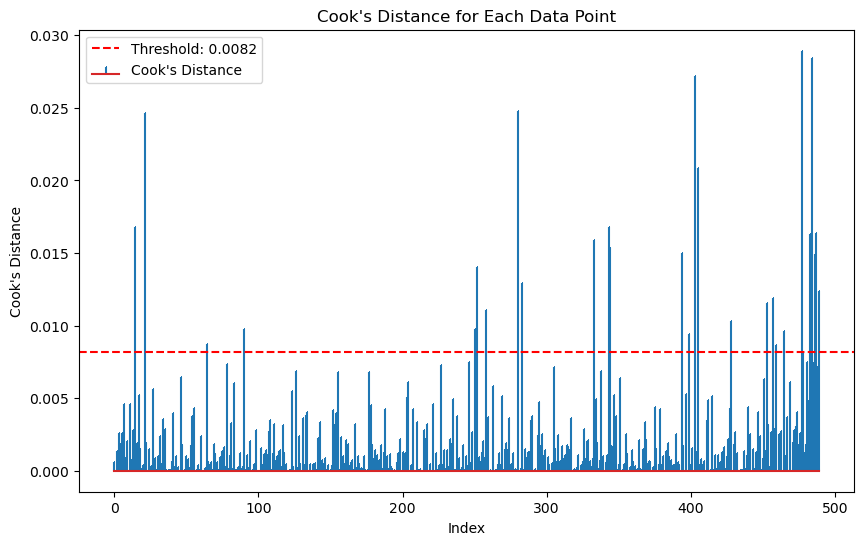

In [39]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance


# Determine n (number of observations) and p (number of predictors)
n = X_with_intercept.shape[0]  # Number of rows in the data (observations)
p = X_with_intercept.shape[1]  # Number of columns in X_with_intercept (predictors + intercept)

# Calculate the threshold for Cook's Distance
threshold = 4 / len(X_with_intercept)

outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

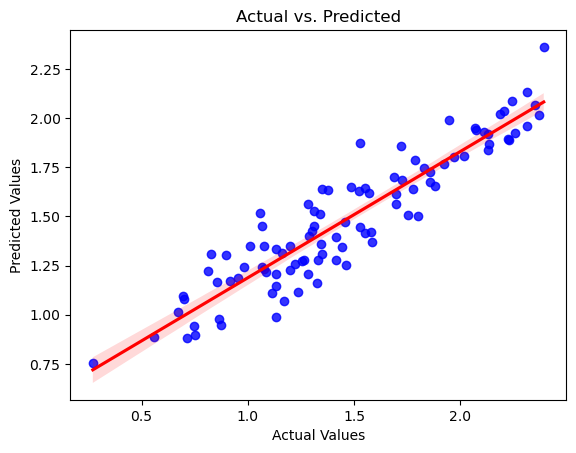

In [40]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Making Predicitons on Current Season Data

We save "ridge_cv_log" for reproductible results. We can then use it to make predictions on the current statistics of players (from 2023-2024 season to the current 2024-2025 season).

In [41]:
joblib.dump(ridge_cv_log, 'ridge_cv_model.pkl')
ridge_cv_log_loaded = joblib.load('ridge_cv_model.pkl')

In [42]:
all_seasons = []

for season in range(2023, 2025):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2023-2024
Successfully fetched data for season 2024-2025
     playerId      skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0     8470600          Ryan Suter            D          100       18        0   
1     8470604         Jeff Carter            C           72        4        0   
2     8470610         Zach Parise            L           30        5        0   
3     8470613         Brent Burns            D           98       38        0   
4     8470621         Corey Perry            R           72       11        0   
..        ...                 ...          ...          ...      ...      ...   
959   8484779       Jett Luchanko            C            4        0        0   
960   8484801   Macklin Celebrini            C            7        1        0   
961   8484911         Collin Graf            R            7        2        0   
962   8484958     Maxim Tsyplakov            R           18        8        0   
963   8485105  

In [43]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 35)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [44]:
start_season = "20232024"
end_season = "20242025"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [45]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [46]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 35]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rebounds Created': 'rebounds_created'}, inplace=True)

In [47]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Alexander Nylander", "Jacob Lucchini", ] 
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Alex Nylander", "Jake Lucchini"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [48]:
merged_clutch_goals_prediction = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [49]:
merged_clutch_goals_prediction.drop(columns = 'GP', axis = 1, inplace = True)

In [50]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals_prediction[per_game_string] = merged_clutch_goals_prediction[column] / merged_clutch_goals_prediction['gamesPlayed']

In [51]:
merged_clutch_goals_prediction['clutch_score'] = 0.3 * merged_clutch_goals_prediction['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals_prediction['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals_prediction['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals_prediction['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals_prediction['ot_goals_per_game']

In [52]:
merged_clutch_goals_prediction['clutch_score'] *= 100
merged_clutch_goals_prediction['clutch_score_rank']  = merged_clutch_goals_prediction['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction['clutch_score'] = merged_clutch_goals_prediction['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals_prediction[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
253,Auston Matthews,16.49,1.0
172,Sam Reinhart,15.60,2.0
185,David Pastrnak,12.97,3.0
173,Leon Draisaitl,12.73,4.0
242,Kirill Kaprizov,12.50,5.0
237,Artemi Panarin,12.06,6.0
207,Kyle Connor,11.81,7.0
192,Brayden Point,11.61,8.0
91,Nikita Kucherov,11.24,9.0
213,Mikko Rantanen,11.12,10.0


In [53]:
merged_clutch_goals_prediction.fillna(0, inplace = True)
null_rows = merged_clutch_goals_prediction[merged_clutch_goals_prediction.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, time_on_ice_per_game, regulation_game_winning, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rebounds_created, iCF, ot_goals_per_game, regulation_game_winning_per_game, assists_per_game, goals_up_by_one_per_game, goals_down_by_one_per_game, goals_when_tied_per_game, shots_per_game, ixG_per_game, iFF_per_game, iSCF_per_game, iHDCF_per_game, iCF_per_game, rebounds_created_per_game, clutch_score, clutch_score_rank]
Index: []

[0 rows x 35 columns]


In [54]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals_prediction[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals_prediction[y_var]

In [55]:
X_scaled = StandardScaler().fit_transform(X_adjusted)
X_scaled = np.nan_to_num(X_scaled, nan=0)

epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

y_log = np.log(y + 1)

X_log = np.log(X_shifted)

y_pred = ridge_cv_log_loaded.predict(X_log)

In [56]:
merged_clutch_goals_prediction

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning,goals_up_by_one,...,goals_when_tied_per_game,shots_per_game,ixG_per_game,iFF_per_game,iSCF_per_game,iHDCF_per_game,iCF_per_game,rebounds_created_per_game,clutch_score,clutch_score_rank
253,8479318,Auston Matthews,C,94,44,3,8,1253.60915,5,15.0,...,0.223404,4.521277,0.563723,6.638298,5.457447,2.393617,8.574468,0.851064,16.49,1.0
172,8477933,Sam Reinhart,C,100,52,3,11,1211.57720,8,17.0,...,0.270000,2.800000,0.452100,4.290000,3.480000,1.820000,5.340000,0.580000,15.60,2.0
185,8477956,David Pastrnak,R,101,72,1,7,1193.91650,6,14.0,...,0.227723,4.594059,0.450099,6.376238,4.049505,1.326733,8.603960,0.712871,12.97,3.0
173,8477934,Leon Draisaitl,C,99,76,5,11,1257.78080,6,5.0,...,0.212121,2.666667,0.348990,4.000000,2.868687,1.060606,5.191919,0.434343,12.73,4.0
242,8478864,Kirill Kaprizov,L,92,70,2,10,1313.24780,8,9.0,...,0.206522,3.597826,0.493804,5.358696,4.086957,1.706522,7.641304,0.750000,12.50,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,8478424,Jansen Harkins,C,48,5,0,0,539.74440,0,0.0,...,0.000000,0.791667,0.062083,1.041667,0.562500,0.270833,1.479167,0.125000,0.00,429.0
341,8480870,Bo Groulx,C,45,2,0,0,731.31110,0,0.0,...,0.000000,0.711111,0.081333,1.200000,0.911111,0.422222,1.822222,0.133333,0.00,429.0
265,8479379,Givani Smith,R,40,3,0,0,407.90275,0,0.0,...,0.000000,0.825000,0.094500,1.075000,0.675000,0.475000,1.425000,0.225000,0.00,429.0
52,8475235,Nicolas Deslauriers,L,67,4,0,0,426.91185,0,0.0,...,0.000000,0.791045,0.093284,1.283582,0.761194,0.432836,1.641791,0.089552,0.00,429.0


In [57]:
merged_clutch_goals_prediction['predicted_clutch_score'] = y_pred 
merged_clutch_goals_prediction['log'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) 

In [58]:
merged_clutch_goals_prediction['log_adjusted'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) * 10
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = y_pred * 10
merged_clutch_goals_prediction = merged_clutch_goals_prediction.sort_values(by='predicted_clutch_score_adjusted', ascending = False)
merged_clutch_goals_prediction['log_adjusted'] = merged_clutch_goals_prediction['log_adjusted'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = merged_clutch_goals_prediction['predicted_clutch_score_adjusted'].apply(lambda x: round(x, 2))

### Making the Results Interpretable

To make the results more interpretable, I have made the following changes:
- Player's predicted and clutch score multiplied by 10
- A tier for the player based on how far they are from the mean for clutch score
- A percentage difference between their actual and predicted values
- A classification for the percentage diff

The results will be saved in an Excel file: "Player Clutch Statisticserence


In [59]:
def create_clutch_rankings(df):

    rankings = df.copy()
    
    mean_score = rankings['predicted_clutch_score_adjusted'].mean()
    std_score = rankings['predicted_clutch_score_adjusted'].std()
    
    rankings['standard_deviations'] = (rankings['predicted_clutch_score_adjusted'] - mean_score) / std_score
    
    def assign_tier(z_score):
        if z_score >= 2:
            return 'Franchise'
        elif z_score >= 1.5:
            return 'Elite'
        elif z_score >= 1:
            return 'Above Average'
        elif z_score > -1:
            return 'Below Average'
        else:
            return 'Limited Clutch Impact'
    
    rankings['tier'] = rankings['standard_deviations'].apply(assign_tier)
    
    rankings['vs_predicted'] = ((rankings['log_adjusted' ] - rankings['predicted_clutch_score_adjusted']) / rankings['predicted_clutch_score_adjusted'] * 100).round(2)
    rankings['vs_predicted'] = rankings['vs_predicted'].apply(lambda x: f"+{x}%" if x > 0 else f"{x}%")

    def assign_tier(percentage):
        if z_score >= 2:
            return 'Franchise'
        elif z_score >= 1.5:
            return 'Elite'
        elif z_score >= 1:
            return 'Above Average'
        elif z_score > -1:
            return 'Below Average'
        else:
            return 'Limited Clutch Impact'
            
    def get_prediction_reliability(diff):
        diff_num = float(diff.rstrip('%'))
        if diff_num >= 0:
            if  diff_num <= 10:
                return 'Slightly Overperforming'
            elif diff_num <= 20:
                return 'Overperforming'   
            else:
                return 'Heavily Overperforming'
        elif diff_num <= 0:
            if  diff_num >= -10:
                return 'Slightly Underperforming'
            elif diff_num >= -20:
                return 'Underperforming'   
            else:
                return 'Heavily Underperforming'   

    
    rankings['Prediction Reliability'] = rankings['vs_predicted'].apply(get_prediction_reliability)
    
    output = rankings[[
        'Player',
        'predicted_clutch_score_adjusted',
        'log_adjusted',
        'tier',
        'vs_predicted',
        'Prediction Reliability'
    ]].sort_values('predicted_clutch_score_adjusted', ascending=False)
    
    output = output.reset_index(drop=True)
    output.index = output.index + 1
    
    output.columns = ['Player', 'Predicted Clutch Score', 'Actual Clutch Score', 'Tier', 'Predicted VS Actual', 'Reliability']

    output.to_excel("Player Clutch Statistics.xlsx")
    
    return output

In [60]:
create_clutch_rankings(merged_clutch_goals_prediction)

,Player,Predicted Clutch Score,Actual Clutch Score,Tier,Predicted VS Actual,Reliability
1,Auston Matthews,24.48,28.62,Franchise,+16.91%,Overperforming
2,Nathan MacKinnon,23.79,24.42,Franchise,+2.65%,Slightly Overperforming
3,David Pastrnak,23.48,26.37,Franchise,+12.31%,Overperforming
4,Brady Tkachuk,23.47,23.20,Franchise,-1.15%,Slightly Underperforming
5,Jake Guentzel,23.45,20.48,Franchise,-12.67%,Underperforming
...,...,...,...,...,...,...
431,Ryan Reaves,10.73,5.71,Limited Clutch Impact,-46.78%,Heavily Underperforming
432,Chris Tierney,10.69,10.04,Limited Clutch Impact,-6.08%,Slightly Underperforming
433,Austin Watson,10.13,9.97,Limited Clutch Impact,-1.58%,Slightly Underperforming
434,Kurtis MacDermid,8.48,8.20,Limited Clutch Impact,-3.3%,Slightly Underperforming


### Cook's Distance Observations

The model shows the same patterns as before - it undervalues and overvalues some players. A few differences are also amplified by the log transformation.

There are 23 influential points.
Outliers based on Cook's Distance:
                  Player    Actual  Predicted  Cook's Distance
136        Jake Guentzel  2.047693   2.529370         0.015327
179         Sonny Milano  2.020222   1.068033         0.045191
280      Michael Carcone  1.969906   1.121401         0.028744
83      Vincent Trocheck  1.943049   2.338153         0.009514
281       Justin Brazeau  1.921325   1.432463         0.009218
374      Simon Holmstrom  1.726332   1.169674         0.015212
288       Vinni Lettieri  1.342865   0.900261         0.009773
60      Evgeny Kuznetsov  1.118415   1.565134         0.009501
66         Austin Watson  0.996949   0.484016         0.015331
27        Max Pacioretty  0.916291   1.563183         0.010685
411  Alexander Barabanov  0.832909   1.484658         0.018668
130     Kurtis MacDermid  0.819780   0.200751         0.053290
190     Christian Dvorak  0.810930   1.301396         0.012801
141           Miles Wood  0.779325   1.604028     

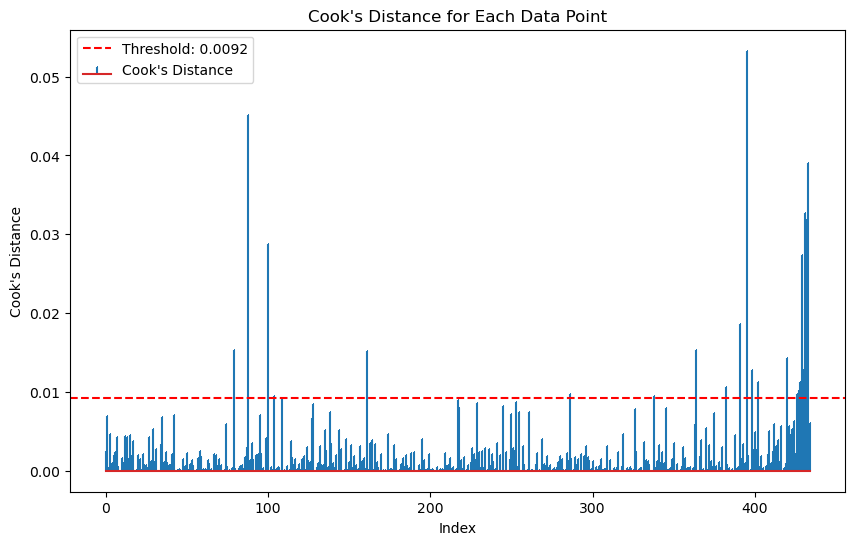

In [61]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)

outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals_prediction.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

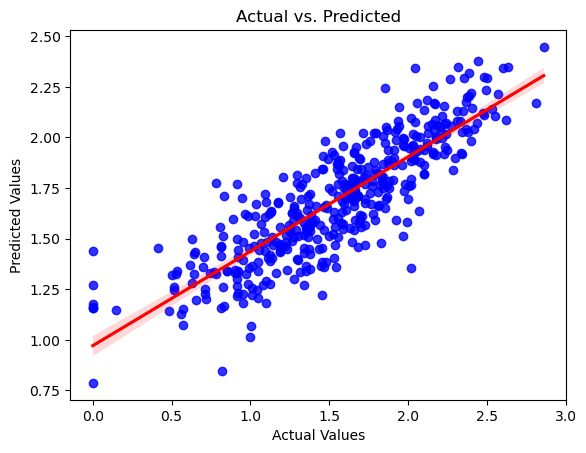

In [62]:
sns.regplot(data=merged_clutch_goals_prediction, x=merged_clutch_goals_prediction['log'], y=merged_clutch_goals_prediction['predicted_clutch_score'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Concluding Thoughts
Through this project, I hope that I have built a well-tuned regression model that is able to perform well in predicting the clutch score of NHL players. Although Cook's distance did identify some influential points in the final model, these points may be useful in determining overvalued and undervalued players.

I hope to deploy this model with Flask or Django and connect it to a PowerBI dashboard to provide real-time updates on the clutch performance of players.